In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# data preprocessing for the CIC-IDS2018 datasets 

In [ ]:
# Configuration
DATA_PATH    = "cic_ids2018.csv"   # ← adjust!
LABEL_COLUMN = "Label"            # ← adjust to your target column
CLIENTS      = 5
ALPHA        = 0.5                       # Dirichlet concentration (smaller → more skew)

In [ ]:
# Load & Inspect
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
print(df[LABEL_COLUMN].value_counts())

Raw shape: (745708, 67)
Label
Benign                      641416
DDoS attacks-LOIC-HTTP       57516
DDOS attack-HOIC             19859
DoS attacks-Hulk             14464
DoS attacks-SlowHTTPTest      6608
DoS attacks-GoldenEye         4051
DoS attacks-Slowloris         1572
DDOS attack-LOIC-UDP           222
Name: count, dtype: int64


In [4]:
#Basic Cleaning
df = df.dropna().drop_duplicates().reset_index(drop=True)
print("After clean:", df.shape)

After clean: (740705, 67)


In [ ]:
#abel encoding 
le = LabelEncoder()
df[LABEL_COLUMN] = le.fit_transform(df[LABEL_COLUMN])
#   0 → benign, 1 → malicious, 2/3… → specific attack types
print("Classes:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes: {'Benign': np.int64(0), 'DDOS attack-HOIC': np.int64(1), 'DDOS attack-LOIC-UDP': np.int64(2), 'DDoS attacks-LOIC-HTTP': np.int64(3), 'DoS attacks-GoldenEye': np.int64(4), 'DoS attacks-Hulk': np.int64(5), 'DoS attacks-SlowHTTPTest': np.int64(6), 'DoS attacks-Slowloris': np.int64(7)}


In [7]:
# Split Features / Target
X = df.drop(columns=[LABEL_COLUMN]).values
y = df[LABEL_COLUMN].values

In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape[0]}  Test: {X_test.shape[0]}")

Train: 592564  Test: 148141


In [10]:
# Train/Test Split (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape[0]}  Test: {X_test.shape[0]}")

Train: 592564  Test: 148141


In [11]:
# Simulate Non‑IID Client Partitions via Dirichlet
def make_dirichlet_splits(y, n_clients, alpha):
    """Return a list of arrays of indices for each client."""
    n_classes = np.max(y) + 1
    # draw mixing proportions for each class
    class_prop = np.random.dirichlet([alpha]*n_clients, size=n_classes)
    # for each class, split its samples according to the proportions
    idx_by_class = [np.where(y == k)[0] for k in range(n_classes)]
    client_idx = [[] for _ in range(n_clients)]
    for k, ids in enumerate(idx_by_class):
        np.random.shuffle(ids)
        proportions = class_prop[k]
        # partition the ids array into chunks
        splits = (proportions.cumsum() * len(ids)).astype(int)
        start = 0
        for i, end in enumerate(splits):
            client_idx[i].extend(ids[start:end])
            start = end
    return [np.array(idx) for idx in client_idx]

client_indices = make_dirichlet_splits(y_train, CLIENTS, ALPHA)

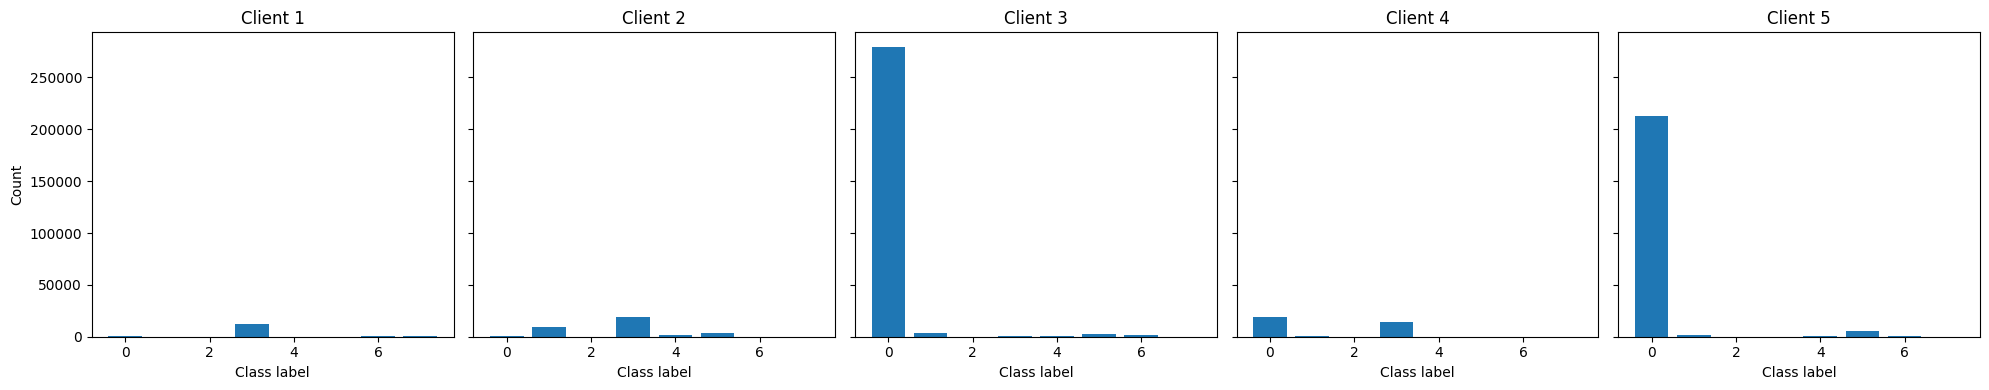

In [13]:
# Plot per‑client class distributions
fig, axes = plt.subplots(1, CLIENTS, figsize=(4*CLIENTS,4), sharey=True)
for i, ax in enumerate(axes):
    counts = np.bincount(y_train[client_indices[i]], minlength=np.max(y_train)+1)
    ax.bar(range(len(counts)), counts)
    ax.set_title(f"Client {i+1}")
    ax.set_xlabel("Class label")
    if i==0: ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

# UNSW-NB15 dataset preprocessing and the clinet distributions 

In [17]:
# 1) Configuration
DATA_PATH    = "UNSW_NB15"   # ← adjust!
LABEL_COLUMN = "Label"            # ← adjust to your target column
CLIENTS      = 5
ALPHA        = 0.5                       # Dirichlet concentration (smaller → more skew) 

Dataset Shape: (528458, 11)
   seq    stddev  N_IN_Conn_P_SrcIP       min  state_number      mean  \
0    9  0.068909                 75  0.000000             1  0.068909   
1   10  0.000000                  2  0.000131             2  0.000131   
2   11  0.064494                 75  0.000000             1  0.064494   
3   12  0.064189                 75  0.000000             1  0.064189   
4   13  0.063887                 75  0.000000             1  0.063887   

   N_IN_Conn_P_DstIP      drate     srate       max  Label  
0                 96  14.511893  0.566862  0.137818      0  
1                  1   0.000000  0.000000  0.000131      0  
2                 96  15.505319  0.567549  0.128988      0  
3                 96  15.578993  0.567570  0.128378      0  
4                 96  15.652637  0.567630  0.127774      0  

Anomaly Counts:
 Anomaly
Normal     475649
Anomaly     52809
Name: count, dtype: int64


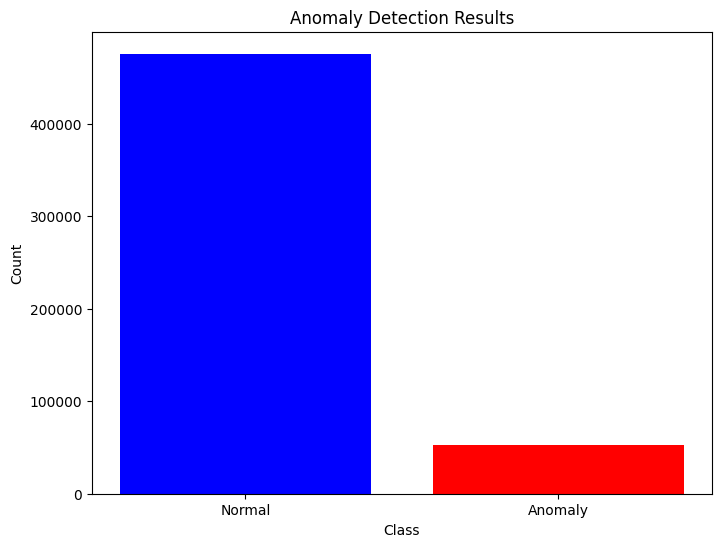

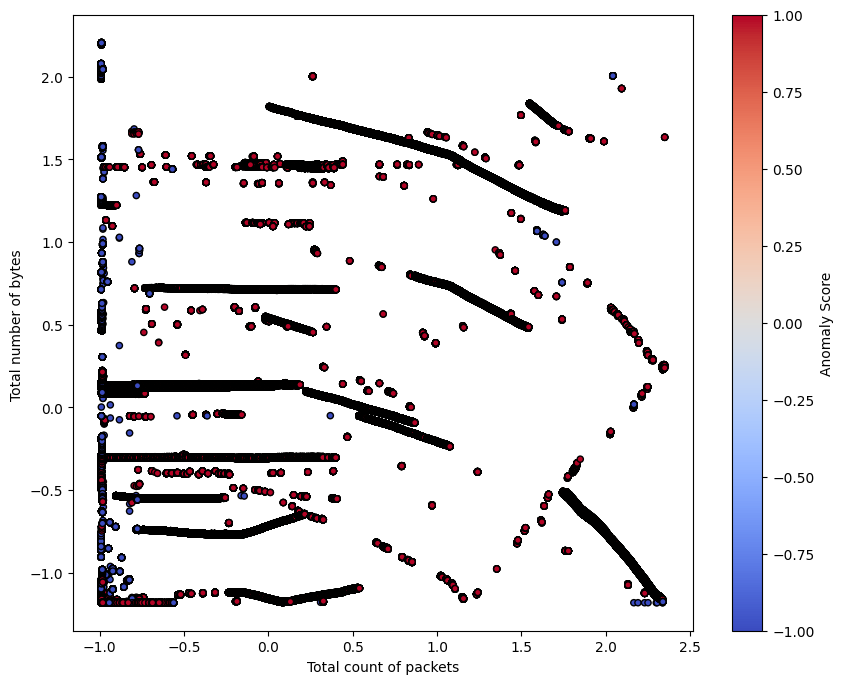

Results saved to 'BoT-IoT_with_anomalies.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load the dataset
# Replace this with the actual path to your BoT-IoT dataset
data_path = 'UNSW_NB15.csv'
data = pd.read_csv(data_path)

# Preview dataset
print("Dataset Shape:", data.shape)
print(data.head())

# Step 2: Preprocess the dataset
# Select numerical features (adjust column names to match your dataset)
# Assume the "Label" column is the ground truth
features = data.drop(columns=['Label','N_IN_Conn_P_SrcIP','state_number'])  
labels = data['Label']  # Target labels (Normal/Attack)

# Standardize the numerical features for Isolation Forest
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Apply Isolation Forest
contamination_level = 0.1  # Adjust based on expected anomaly percentage
isolation_forest = IsolationForest(n_estimators=100, contamination=contamination_level, random_state=42)
data['Anomaly_Score'] = isolation_forest.fit_predict(features_scaled)
data['Anomaly'] = data['Anomaly_Score'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# Step 4: Evaluate and Visualize Results
# Count anomalies and normal points
anomaly_counts = data['Anomaly'].value_counts()
print("\nAnomaly Counts:\n", anomaly_counts)

# Bar Plot: Anomaly vs. Normal
plt.figure(figsize=(8, 6))
plt.bar(anomaly_counts.index, anomaly_counts.values, color=['blue', 'red'])
plt.title('Anomaly Detection Results')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Scatter Plot: Visualize 2 features (adjust feature columns as needed)
plt.figure(figsize=(10, 8))
plt.scatter(
    features_scaled[:, 0], features_scaled[:, 1],
    c=data['Anomaly_Score'],
    cmap='coolwarm',
    edgecolor='k',
    s=20
)
#plt.title('Isolation Forest Results (Scatter Plot)')
plt.xlabel('Total count of packets')
plt.ylabel('Total number of bytes ')
plt.colorbar(label='Anomaly Score')
plt.savefig('anomalyscatterbot.eps', format='eps', dpi=300)
plt.show()

# Step 5: Save Results
output_file = 'BoT-IoT_with_anomalies.csv'
data.to_csv(output_file, index=False)
print(f"Results saved to '{output_file}'")

In [22]:
# 1) Configuration
DATA_PATH    = "UNSW_NB15.csv"   # ← adjust!
LABEL_COLUMN = "Label"            # ← adjust to your target column
CLIENTS      = 5
ALPHA        = 0.5 

In [23]:
# Load & Inspect
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
print(df[LABEL_COLUMN].value_counts())

Raw shape: (66691, 56)
Label
1    56691
0    10000
Name: count, dtype: int64


In [24]:
df = df.dropna().drop_duplicates().reset_index(drop=True)
print("After clean:", df.shape)

After clean: (66691, 56)


In [25]:
le = LabelEncoder()
df[LABEL_COLUMN] = le.fit_transform(df[LABEL_COLUMN])
#   0 → benign, 1 → malicious, 2/3… → specific attack types
print("Classes:", dict(zip(le.classes_, le.transform(le.classes_))))

Classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}


In [26]:
X = df.drop(columns=[LABEL_COLUMN]).values
y = df[LABEL_COLUMN].values

In [27]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train: {X_train.shape[0]}  Test: {X_test.shape[0]}")

Train: 53352  Test: 13339


In [29]:
# Simulate Non‑IID Client Partitions via Dirichlet
def make_dirichlet_splits(y, n_clients, alpha):
    """Return a list of arrays of indices for each client."""
    n_classes = np.max(y) + 1
    # draw mixing proportions for each class
    class_prop = np.random.dirichlet([alpha]*n_clients, size=n_classes)
    # for each class, split its samples according to the proportions
    idx_by_class = [np.where(y == k)[0] for k in range(n_classes)]
    client_idx = [[] for _ in range(n_clients)]
    for k, ids in enumerate(idx_by_class):
        np.random.shuffle(ids)
        proportions = class_prop[k]
        # partition the ids array into chunks
        splits = (proportions.cumsum() * len(ids)).astype(int)
        start = 0
        for i, end in enumerate(splits):
            client_idx[i].extend(ids[start:end])
            start = end
    return [np.array(idx) for idx in client_idx]

client_indices = make_dirichlet_splits(y_train, CLIENTS, ALPHA)

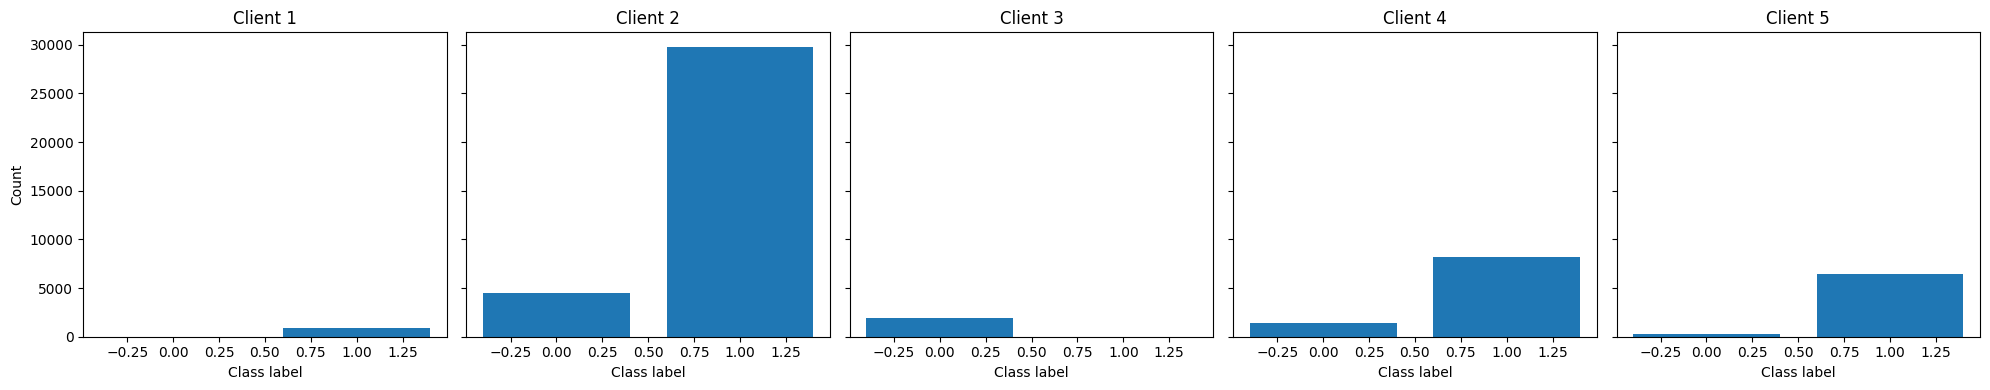

In [30]:
# Plot per‑client class distributions
fig, axes = plt.subplots(1, CLIENTS, figsize=(4*CLIENTS,4), sharey=True)
for i, ax in enumerate(axes):
    counts = np.bincount(y_train[client_indices[i]], minlength=np.max(y_train)+1)
    ax.bar(range(len(counts)), counts)
    ax.set_title(f"Client {i+1}")
    ax.set_xlabel("Class label")
    if i==0: ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
def preprocess_data(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
    return X_scaled, y

def load_data():
    # Update with the path to your dataset
    path = 'cic_ids2018.csv'
    data = pd.read_csv(path)
    
    X = data.drop(columns=['Label']).to_numpy()
    y = pd.get_dummies(data['Label']).to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train, y_train = preprocess_data(X_train, y_train)
    X_test, y_test = preprocess_data(X_test, y_test)
    
    return X_train, X_test, y_train, y_test